## Imports and setup

In [36]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from IPython.display import Image

from project.utils import multi_hot, make_iou, f1, decode_image_predictions
from project.models import create_model_with_feature_extractor
from project.preprocess_ingredients import preprocess_ingredients, decode_ingredients
from project.dataset import load_dataset_for_ingredient_prediction, load_image, load_image_as_pixels, \
    train_val_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
DATASET_ROOT = os.path.join("project", "dataset")
DATASET_CSV_PATH = os.path.join(DATASET_ROOT, "Food Ingredients and Recipe Dataset with Image Name Mapping.csv")

IMG_SIZE = 224
CROP_SIZE = 200
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IOU_THRESH = 0.5
FEATURE_EXTRACTOR = "resnet"

N_TESTS = 20

## GPU check

In [3]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load dataset

In [4]:
images, ingredients, valid_ingredients_list, dataset_size = load_dataset_for_ingredient_prediction(
    csv_file_path=DATASET_CSV_PATH, 
    preprocess_func=preprocess_ingredients,
    is_ipynb=True
)

NUM_INGREDIENTS = len(valid_ingredients_list)

#multi-hot encode ingredients
ingredients_multihot = ingredients.map(lambda x: multi_hot(x, NUM_INGREDIENTS), num_parallel_calls=tf.data.AUTOTUNE)

Dataset columns: ['id', 'Title', 'Ingredients', 'Instructions', 'Image_Name', 'Cleaned_Ingredients']
Removed 8 rows containing NaN
current path for images: project\dataset\Food Images\Food Images


In [5]:
#split in the same manner as training pipeline
#train/val/test split
train_x, validation_x, test_x = train_val_test_split(images, dataset_size)
train_y, validation_y, test_y = train_val_test_split(ingredients_multihot, dataset_size)

print(train_x.cardinality().numpy(), "train samples")
print(validation_x.cardinality().numpy(), "validation samples")
print(test_x.cardinality().numpy(), "test samples")

8615 train samples
2154 validation samples
2693 test samples


## Image preprocessing layers

In [6]:
#for evaluation, just scale to expected feature extractor input size
resize = layers.Resizing(CROP_SIZE, CROP_SIZE)

(200, 200, 3)
<dtype: 'float32'>


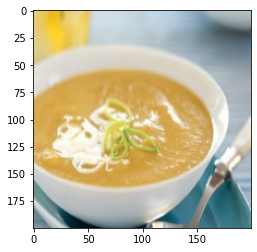

In [51]:
#apply resizing to testing input
test_x_resized = test_x.map(resize, num_parallel_calls=tf.data.AUTOTUNE)

test_images = [e.numpy() for e in test_x_resized.take(N_TESTS)]

for img in test_x_resized:
    print(img.shape)
    #not sure why this is float type here, images are loaded as uint8
    #maybe keras preprocessing layers convert to float
    print(img.dtype)
    plt.figure()
    _ = plt.imshow(img / 255.) #divide by 255 here so image can be shown
    break

## Create model

In [8]:
# Load pre-trained feature extractor
if FEATURE_EXTRACTOR == "resnet":
    feature_extractor = ResNet50(include_top=False, weights='imagenet', input_shape=(CROP_SIZE, CROP_SIZE, 3))
    feature_extractor_preprocessor = resnet50_preprocess
else:
    feature_extractor = MobileNetV2(include_top=False, weights="imagenet", input_shape=(CROP_SIZE, CROP_SIZE, 3))
    feature_extractor_preprocessor = mobilenetv2_preprocess


#disable updating the feature extractor parameters
feature_extractor.trainable = False

In [9]:
#final preprocessing for pretrained feature extractor
test_x_resized = test_x_resized.map(feature_extractor_preprocessor, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
#create iou metric
iou = make_iou(IOU_THRESH)

#create model and load trained predictor weights
model, ingredient_predictor = create_model_with_feature_extractor(
    num_ingredients=NUM_INGREDIENTS,
    feature_extractor=feature_extractor,
    metrics=['accuracy', iou, f1],
    #TODO here: get model from "best" (or really, any) run, and evaluate it
    model_file=os.path.join("best-runs", "best-resnet-cef58318-a912-46ca-9970-4cc1da7ca1e0", "ingredient_predictor.keras")
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 ingredient_predictor (Seque  (None, 208)              426192    
 ntial)                                                          
                                                                 
Total params: 24,013,904
Trainable params: 426,192
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
#create test dataset by zipping/batching
test_ds = Dataset.zip((test_x_resized, test_y))
test_ds_nonbatched = test_ds
test_ds = test_ds.batch(BATCH_SIZE)

In [12]:
results = model.evaluate(test_ds, return_dict=True)

85/85 [==============================] - 52s 422ms/step - loss: 0.1191 - accuracy: 0.3847 - iou: 0.1186 - f1: 0.2104


In [13]:
results

{'loss': 0.11913497000932693,
 'accuracy': 0.38470107316970825,
 'iou': 0.11858414113521576,
 'f1': 0.21042212843894958}

In [71]:
# for img, x, true_y in zip(test_images, test_x_resized.take(N_TESTS), test_y.take(N_TESTS)):
#     plt.figure()
#     _ = plt.imshow(x / 255.) #divide by 255 here so image can be shown
#     x = np.expand_dims(x, 0)
#     pred_y = model.predict(x)[0]
#     true_ing = decode_image_predictions(true_y, valid_ingredients_list)
#     pred_ing = decode_image_predictions(pred_y, valid_ingredients_list)
#     print("true ingredients:", true_ing)
#     print("pred ingredients:", pred_ing)
    
def run_pred(n):
    for i, (img, x, true_y) in enumerate(zip(test_images, test_x_resized.take(N_TESTS), test_y.take(N_TESTS))):
        if i == n:
            plt.figure()
            plt.axis("off")
            _ = plt.imshow(x / 255.) #divide by 255 here so image can be shown
            x = np.expand_dims(x, 0)
            pred_y = model.predict(x)[0]
            true_ing = decode_image_predictions(true_y, valid_ingredients_list)
            pred_ing = decode_image_predictions(pred_y, valid_ingredients_list)
            print("true ingredients:", true_ing)
            print("pred ingredients:", pred_ing)


1/1 [==============================] - 0s 58ms/step
true ingredients: ['coriander seeds', 'creme fraiche', 'lemon peel', 'olive oil', 'sour cream', 'vegetable broth']
pred ingredients: ['black pepper', 'garlic cloves', 'heavy cream', 'lemon juice', 'lemon zest', 'lime juice', 'olive oil', 'parsley', 'salt', 'sugar']


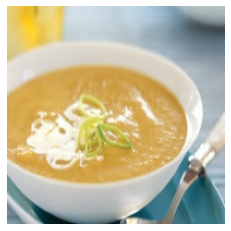

In [72]:
run_pred(0)

1/1 [==============================] - 0s 151ms/step
true ingredients: ['ice', 'lime juice', 'simple syrup']
pred ingredients: ['black pepper', 'lemon juice', 'lime juice', 'milk', 'olive oil', 'salt', 'sugar']


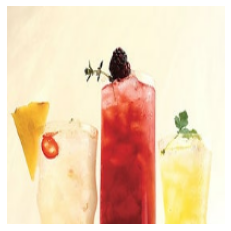

In [73]:
run_pred(1)

1/1 [==============================] - 0s 53ms/step
true ingredients: ['basil', 'olive oil', 'white-wine vinegar']
pred ingredients: ['all-purpose flour', 'garlic cloves', 'lime juice', 'milk', 'olive oil', 'red onion', 'salt', 'sugar', 'unsalted butter', 'vegetable oil', 'white wine']


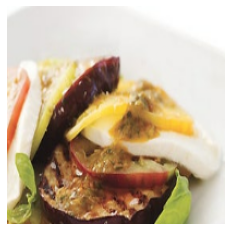

In [74]:
run_pred(5)

1/1 [==============================] - 0s 50ms/step
true ingredients: ['ice']
pred ingredients: ['honey', 'lemon juice', 'salt', 'sugar']


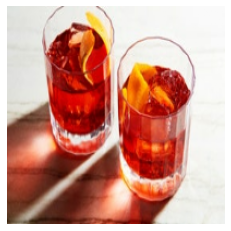

In [85]:
run_pred(6)

1/1 [==============================] - 0s 70ms/step
true ingredients: ['baby arugula', 'basil', 'garlic cloves', 'lemon', 'lemon juice', 'olive oil', 'red-pepper flakes', 'red-wine vinegar', 'salt', 'sugar']
pred ingredients: ['egg', 'garlic cloves', 'olive oil', 'parsley', 'salt', 'sesame seeds', 'sugar']


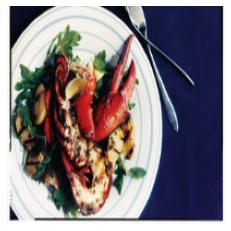

In [84]:
run_pred(10)

1/1 [==============================] - 0s 43ms/step
true ingredients: ['black pepper', 'dill', 'olive oil', 'salt', 'shallots', 'unsalted butter']
pred ingredients: ['all-purpose flour', 'baking powder', 'cinnamon', 'heavy cream', 'lemon juice', 'olive oil', 'parsley', 'salt', 'sugar', 'unsalted butter']


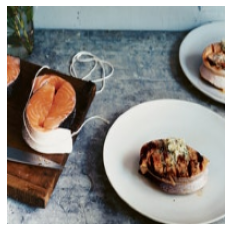

In [83]:
run_pred(11)

1/1 [==============================] - 0s 53ms/step
true ingredients: ['allspice', 'bay leaf', 'black peppercorns', 'dijon mustard', 'dill', 'lemon zest', 'mayonnaise', 'onion', 'sour cream', 'tarragon']
pred ingredients: ['black pepper', 'garlic cloves', 'lemon juice', 'salt', 'sugar', 'unsalted butter', 'water', 'whipping cream']


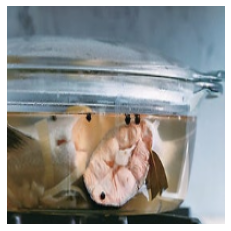

In [75]:
run_pred(12)

1/1 [==============================] - 0s 48ms/step
true ingredients: ['brown sugar', 'ginger', 'lime', 'lime juice', 'olive oil', 'red wine', 'rice wine', 'soy sauce']
pred ingredients: ['black pepper', 'lemon juice', 'misc', 'olive oil', 'red onion', 'salt', 'sugar', 'water']


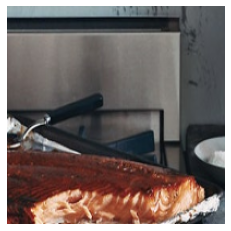

In [76]:
run_pred(13)

1/1 [==============================] - 0s 48ms/step
true ingredients: ['bacon', 'bay leaf', 'black pepper', 'chives', 'garlic cloves', 'heavy cream', 'lemon juice', 'milk', 'red-pepper flakes', 'salt', 'thyme']
pred ingredients: ['all-purpose flour', 'black pepper', 'egg', 'garlic cloves', 'greek yogurt', 'lemon juice', 'lemon zest', 'lime juice', 'olive oil', 'parsley', 'salt', 'sugar', 'unsalted butter']


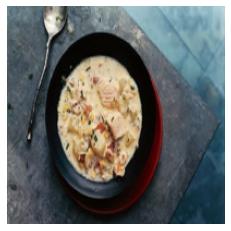

In [77]:
run_pred(14)

1/1 [==============================] - 0s 60ms/step
true ingredients: ['basil leaves', 'black pepper', 'dijon mustard', 'garlic cloves', 'mayonnaise', 'olive oil', 'orange zest', 'plum tomatoes', 'saffron', 'salt', 'water', 'white wine']
pred ingredients: ['black pepper', 'bourbon', 'lemon juice', 'lime juice', 'mint leaves', 'misc', 'parmesan cheese', 'rice vinegar', 'salt', 'sesame seeds', 'sugar', 'white vinegar']


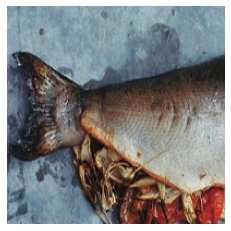

In [78]:
run_pred(15)

1/1 [==============================] - 0s 51ms/step
true ingredients: ['all-purpose flour', 'allspice', 'baking powder', 'brown sugar', 'cinnamon', 'ice cream', 'milk', 'potatoes', 'salt', 'unsalted butter', 'vanilla extract', 'water']
pred ingredients: ['all-purpose flour', 'bay leaf', 'brown sugar', 'cinnamon', 'cumin', 'egg', 'garlic cloves', 'greek yogurt', 'heavy cream', 'lemon juice', 'lemon zest', 'lime juice', 'milk', 'mint leaves', 'olive oil', 'onion', 'parsley', 'salt', 'sour cream', 'sugar', 'vegetable oil']


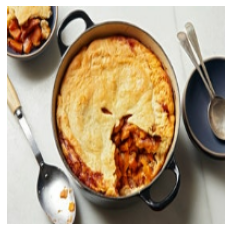

In [79]:
run_pred(16)

1/1 [==============================] - 0s 56ms/step
true ingredients: ['garlic cloves', 'olive oil', 'parsley leaves', 'potatoes', 'red-pepper flakes', 'salt', 'sherry vinegar']
pred ingredients: ['all-purpose flour', 'cinnamon', 'egg', 'garlic cloves', 'lemon juice', 'lime juice', 'olive oil', 'onion', 'parsley', 'salt', 'shallots', 'sugar']


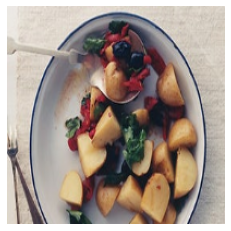

In [80]:
run_pred(17)

1/1 [==============================] - 0s 45ms/step
true ingredients: ['ice cream']
pred ingredients: ['lemon juice', 'salt', 'sugar']


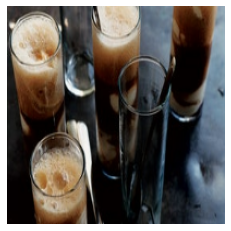

In [81]:
run_pred(18)

1/1 [==============================] - 0s 43ms/step
true ingredients: ['black pepper', 'garlic cloves', 'lemon juice', 'misc', 'olive oil', 'parsley', 'red-bell pepper', 'salt']
pred ingredients: ['all-purpose flour', 'garlic cloves', 'honey', 'lemon juice', 'milk', 'olive oil', 'salt', 'sugar', 'unsalted butter', 'vanilla extract']


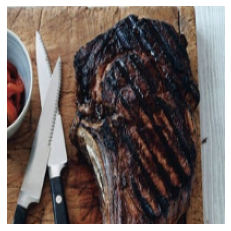

In [82]:
run_pred(19)

In [70]:
run_pred(20)